In [1]:
import nltk

In [2]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [3]:
stopwords = nltk.corpus.stopwords.words('english')

In [4]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [5]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
movieTextFileNames = []

In [7]:
for filename in os.listdir('subs_CSV'):
    contents = open('subs_CSV/' + filename, "r", encoding='utf-8', errors='ignore')
    movieTextFileNames.append(filename)

In [8]:
print(movieTextFileNames)

['starwarsphantommenace.csv', 'cityofgod.csv', 'darkknight.csv', 'lotr_returnofking.csv', 'toystory3.csv', 'usualsuspects.csv', '.DS_Store', 'forrestgump.csv', 'harrypotterorderphoenix.csv', 'lotr_thehobbit.csv', 'shrek2.csv', 'piratesofcarib_atworldsend.csv', 'onceuponatimeinthewest.csv', 'inception.csv', 'piratesofcarib_onstrangertides.csv', 'thematrix.csv', 'darkknightrises.csv', 'twelveangrymen.csv', 'avatar.csv', 'starwars_empirestrikesback.csv', 'jurassicpark.csv', 'lotr_twotowers.csv', 'schindlerslist.csv', 'se7en.csv', 'casablanca.csv', 'transformers_darkmoon.csv', 'avengers.csv', 'findingnemo.csv', 'titanic.csv', 'skyfall.csv', 'godfather.csv', 'harrypotterhalfblood.csv', 'goodfellas.csv', 'lionking.csv', 'sevensamurai.csv', 'goodbadugly.csv', 'lotr_fellowship.csv', 'aliceinwonderland2010.csv', 'harrypotter7.csv', 'indianajones_raidersofthelostark.csv', 'harrypottersorcstone.csv', 'starwarsnewhope.csv', 'silenceofthelambs.csv', 'ironman3.csv', 'fightclub.csv', 'oneflewovercuck

In [9]:
movieTextFileNames[6] #ugh I imported this file on accident, need to delete it

'.DS_Store'

In [10]:
movieTextFileNames.remove('.DS_Store')

In [11]:
len(movieTextFileNames) # should be 50 movie subtitle filenames without the dsstore file.

50

In [12]:
movieTexts = []
for filename in movieTextFileNames:
    contents = open('subs_CSV/' + filename, "r", encoding='utf-8', errors='ignore')
    movieTexts.append(contents.read())

In [13]:
len(movieTexts)

50

In [14]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for movieText in movieTexts:
    allwords_stemmed = tokenize_and_stem(movieText)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(movieText)
    totalvocab_tokenized.extend(allwords_tokenized)

In [15]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(movieTexts)

print(tfidf_matrix.shape)

CPU times: user 25.2 s, sys: 253 ms, total: 25.4 s
Wall time: 25.8 s
(50, 2200)


In [17]:
terms = tfidf_vectorizer.get_feature_names()

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [19]:
from sklearn.cluster import KMeans

num_clusters = 4 # you can re-do this analysis, 
# choose different cluster numbers 
# and examine the silhouette and cluster assignments along with meta-data on each movie

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 1.06 s, sys: 41.6 ms, total: 1.1 s
Wall time: 1.29 s


In [20]:
print(vocab_frame)

                  words
long               long
time               time
ago                 ago
in                   in
a                     a
galaxi           galaxy
far                 far
far                 far
away               away
captain         captain
yes                 yes
sir                 sir
tell               tell
them               them
we                   we
wish               wish
to                   to
board             board
at                   at
onc                once
with               with
all                 all
due                 due
respect         respect
the                 the
ambassador  ambassadors
for                 for
the                 the
suprem          supreme
chancellor   chancellor
...                 ...
you                 you
you                 you
can                 can
choos            choose
gryffindor   gryffindor
the                 the
sort            sorting
hat                 hat
take              takes
your            

In [21]:
import pandas as pd

films = { 'movieTextFileNames': movieTextFileNames, 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['movieTextFileNames', 'cluster'])

In [22]:
frame['cluster'].value_counts()

2    29
3    10
1     8
0     3
Name: cluster, dtype: int64

In [23]:
grouped = frame['movieTextFileNames'].groupby(frame['cluster'])

# grouped.mean() # use this once you open the meta-data (eg, audience ratings)

In [24]:
print(grouped)

In [25]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['movieTextFileNames'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'sam', b'ring', b'merry', b'yells', b'king', b'precious',

Cluster 0 titles: lotr_returnofking.csv, lotr_twotowers.csv, lotr_fellowship.csv,

Cluster 1 words: b'fuck', b'shit', b'guys', b'wan', b'wan', b'mr.',

Cluster 1 titles: cityofgod.csv, usualsuspects.csv, se7en.csv, goodfellas.csv, fightclub.csv, oneflewovercuckoosnest.csv, shawshank.csv, pulpfiction.csv,

Cluster 2 words: b'okay', b'jacked', b'ships', b'guys', b'captain', b'mr.',

Cluster 2 titles: starwarsphantommenace.csv, darkknight.csv, toystory3.csv, forrestgump.csv, lotr_thehobbit.csv, piratesofcarib_atworldsend.csv, onceuponatimeinthewest.csv, inception.csv, piratesofcarib_onstrangertides.csv, thematrix.csv, darkknightrises.csv, twelveangrymen.csv, avatar.csv, starwars_empirestrikesback.csv, jurassicpark.csv, schindlerslist.csv, casablanca.csv, transformers_darkmoon.csv, avengers.csv, titanic.csv, skyfall.csv, sevensamurai.csv, goodbadugly.csv, indianajones_raidersofthelostark.cs

In [26]:
# to visualize clusters, we need to use multi-dimensional scaling to project 
# multi-dimensional data to two

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [27]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [28]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
# add more colors if you want more clusters

#set up cluster names using a dict
cluster_names = {0: 'cluster 1', 
                 1: 'cluster 2', 
                 2: 'cluster 3', 
                 3: 'cluster 4'}

In [29]:
%matplotlib inline

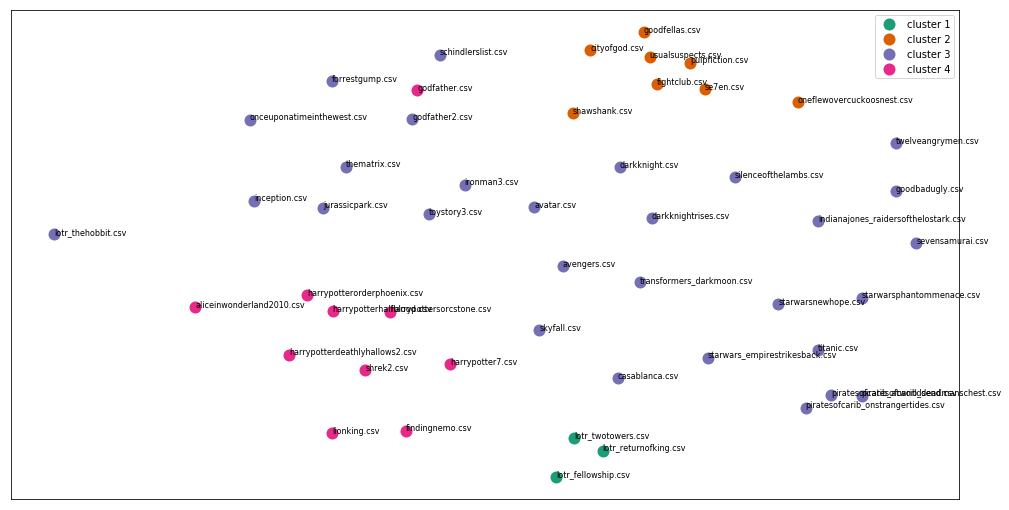

In [30]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=movieTextFileNames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)